In [39]:
import pandas as pd 

In [40]:
df = pd.read_csv("IMDB Dataset.csv")

In [41]:
pd.set_option('future.no_silent_downcasting', True)
df = df.replace({"positive": 1, "negative": 0}).infer_objects(copy=False)

In [42]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Lets get started with some natural langauge processing!

In [43]:
def metrics(actual, predicted):
    # lengths must be the same
    if len(actual) != len(predicted):
        print("error lengths of actual and predicted are not the same.")
        return
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for a, p in zip(actual, predicted):
        if a == 1 and p == 1:
            true_positive += 1
        elif a == 0 and p == 0:
            true_negative += 1
        elif a == 0 and p == 1:
            false_positive += 1
        elif a == 1 and p == 0:
            false_negative += 1

    try:
        accuracy = (true_positive+true_negative)/len(predicted)
        precision = true_positive/(true_positive+false_positive)
        recall = true_positive/(true_positive+false_negative)
        f1 = 2*((precision*recall)/(precision+recall))
    except:
        raise ZeroDivisionError("Division by zero")

    print(f"accuracy:{accuracy:.4f}, Precision:{precision:.4f}, Recall:{recall:.4f}, F1:{f1:.4f}")




## Step one Linear Regression and Bag of Words!


In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load data
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.2, random_state=42)

# Convert text to BoW features
vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)

metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.8766, Precision:0.8730, Recall:0.8837, F1:0.8783


Linear Regression might be the simplest algorithm out there, but isn't it fantastic?

These values will be our baseline model! 

accuracy:0.8848, Precision:0.8804, Recall:0.8892, F1:0.8848

In [45]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

# Bayes expects "dense array"
X_train_dense = X_train_bow.toarray()
X_test_dense = X_test_bow.toarray()

model.fit(X_train_dense, y_train)

y_pred = model.predict(X_test_dense)

metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.7440, Precision:0.8204, Recall:0.6299, F1:0.7126


Maybe not super surprising Bayes might not be kitted for NLP!

One thing we have forgotten about is the data is binary! of course bayes doesn't work!

We could use an SVM, however because a SVM scales with $n_{features}*n^2_{samples}$ the computation is way to slow for my machine :(


## Next step Tfidvectorizer

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.8997, Precision:0.8912, Recall:0.9123, F1:0.9016


A new best model! 

How exiating our new best model is:

accuracy:0.8966, Precision:0.8827, Recall:0.9129, F1:0.8975

Let's try something intresting a PCA?

Problem the pca takes forever! lets try a Truncated SVD much like a PCA!

In [47]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=5, random_state=42)
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.fit_transform(X_test_vec)

model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)


metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.6090, Precision:0.6107, Recall:0.6182, F1:0.6144


Our worst model yet! 

accuracy:0.6012, Precision:0.5973, Recall:0.6271, F1:0.6118

Our data is highly dimentional removing the dimentions makes it worse. Who could have gussed.

These values are slightly better than a random guess which would be 50/50. 

Letter on in this project I will create my very own neural network and see if it outperforms a TruncatedSVD

## SentimentIntensityAnalyzer AKA pretrained model from NLTK

In [48]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
Semtiment = SentimentIntensityAnalyzer()


# Testing some obvious once before
print(f"first: {Semtiment.polarity_scores("If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!")}")
print(f"second: {Semtiment.polarity_scores(("Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."))}")
print(f"Third: {Semtiment.polarity_scores(("Besides being boring, the scenes were oppressive and dark. The movie tried to portray some kind of moral, but fell flat with its message. What were the redeeming qualities?? On top of that, I don't think it could make librarians look any more unglamorous than it did."))}")


first: {'neg': 0.094, 'neu': 0.531, 'pos': 0.375, 'compound': 0.9149}
second: {'neg': 0.166, 'neu': 0.662, 'pos': 0.172, 'compound': 0.2362}
Third: {'neg': 0.079, 'neu': 0.876, 'pos': 0.045, 'compound': -0.168}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\felik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
# approach 1
def vader_sentiment(text):
    score = Semtiment.polarity_scores(text)
    return 1 if score['neg'] < score["pos"] else 0

y_pred = X_test.apply(vader_sentiment)


metrics(y_test.tolist(), y_pred.tolist())

accuracy:0.6940, Precision:0.6473, Recall:0.8629, F1:0.7397


In [50]:
# approach 2 
def vader_sentiment2(text):
    score = Semtiment.polarity_scores(text)
    return 1 if score['compound'] > 0 else 0

y_pred = X_test.apply(vader_sentiment2)


metrics(y_test.tolist(), y_pred.tolist())


accuracy:0.6971, Precision:0.6518, Recall:0.8565, F1:0.7402


Both of these alternatives are not so good, better than a random guess but nothing note worthy 

# Neural networks 

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 4
drop_out_rate = 0.2
output_shape = 1 # binary 0 , 1
hiddenunits = 16
input_shape = 4 # components in the truncatedSVD(after 5 nothing happens)




In [52]:
# Creating the dataset
vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

svd = TruncatedSVD(n_components=input_shape, random_state=42)
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.fit_transform(X_test_vec)

X_train_tensor = torch.tensor(X_train_reduced, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_reduced, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:

class Neuralnet(nn.Module):
    """
    Simple Neural network 
    
    Linear layer
    ReLU activation
    Dropout
    """
    def __init__(self, input_shape, hidden_units, output_shape,drop_out_rate):
        super().__init__()
        self.block_1 = nn.Sequential(nn.Linear(in_features=input_shape, out_features=hidden_units),
                                     nn.ReLU(),
                                    nn.Dropout(drop_out_rate))
        self.block_2 = nn.Sequential(nn.Linear(in_features=hidden_units, out_features=output_shape)
)
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        return x
    
model = Neuralnet(output_shape=output_shape, input_shape=input_shape, hidden_units=hiddenunits, drop_out_rate=drop_out_rate).to(device)

In [54]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss() #binary outcome
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
def train_loop(model, num_epochs, loss_fn, optimizer):
    epoch_losses = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        
        for batch_X, batch_y in training_loader:
            optimizer.zero_grad()  # Reset gradients
            
            # Reshape
            batch_y = batch_y.view(-1, 1)
            
            predictions = model(batch_X)  # Forward pass
            loss = loss_fn(predictions, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(training_loader)
        epoch_losses.append(avg_epoch_loss)
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
    return epoch_losses


In [56]:
# runs train loop and returns epoch_losses
epoch_losses = train_loop(model, 10, loss_fn, optimizer)

Epoch [1/10], Loss: 0.6715
Epoch [6/10], Loss: 0.6575


In [57]:
# eval
def eval_neuralnet(model):
    model.eval()

    predictions = []
    actuals = []

    with torch.no_grad():  
        for batch_X, batch_y in zip(X_test_tensor, y_test_tensor):
            # Get model predictions
            output = torch.sigmoid(model(batch_X.unsqueeze(0)))  # Add batch dimension
            pred = (output > 0.5).float()  # Apply sigmoid and convert to 0 or 1
            
            predictions.append(pred.cpu().numpy().flatten())
            

        return predictions

In [58]:
metrics(y_test.tolist(), eval_neuralnet(model))

accuracy:0.6138, Precision:0.6441, Recall:0.5219, F1:0.5766


In [59]:
"""
# Save models
model_path = 'model1.pth'
torch.save(model.state_dict(), model_path)
"""

"\n# Save models\nmodel_path = 'model1.pth'\ntorch.save(model.state_dict(), model_path)\n"

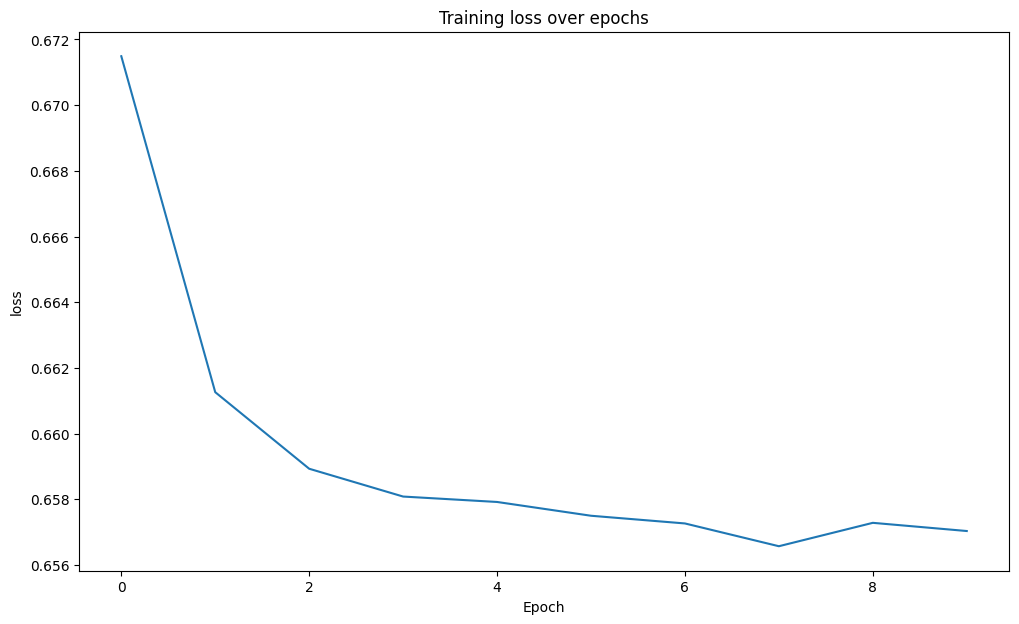

In [60]:
import matplotlib.pyplot as plt
def plot_epoch_losses(epoch_losses):
    plt.figure(figsize=(12, 7))

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.title("Training loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("loss")

plot_epoch_losses(epoch_losses)

After just 7 epochs it plateaus indicating a few possible things. 

Possible overfitting the data after being truncated might not be complex enough to truly analyse.

Insufficient learning a more complex model might be better or adjusting the current model.

Truncating might be the problem here we need another technique for changing the dataset.

In [61]:
type(X_test)

pandas.core.series.Series

In [62]:
# vectorize set max_features to 10000 (pc bottleneck)
vectorizer = TfidfVectorizer(max_features=10000)

data_train = vectorizer.fit_transform(X_train)
data_test = vectorizer.transform(X_test)


data_train_dense = data_train.toarray()  # Convert to dense numpy array
data_test_dense = data_test.toarray()

In [63]:
torch.manual_seed(0)

# add to tensor
X_train_tensor = torch.tensor(data_train_dense, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(data_test_dense, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

#Dataset creation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# test and trainloader
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [64]:
batch_size = 4
drop_out_rate = 0.2
output_shape = 1
hiddenunits = 16
input_shape = 10000 # components in the TfidfVectorizer 

In [65]:
model1 = Neuralnet(output_shape=output_shape, input_shape=input_shape, hidden_units=hiddenunits, drop_out_rate=drop_out_rate).to(device)

In [66]:
loss_fn = nn.BCEWithLogitsLoss() #binary
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [67]:
epoch_losses = train_loop(model1, 25, loss_fn, optimizer)

Epoch [1/25], Loss: 0.3162
Epoch [6/25], Loss: 0.0969
Epoch [11/25], Loss: 0.0468
Epoch [16/25], Loss: 0.0326
Epoch [21/25], Loss: 0.0327


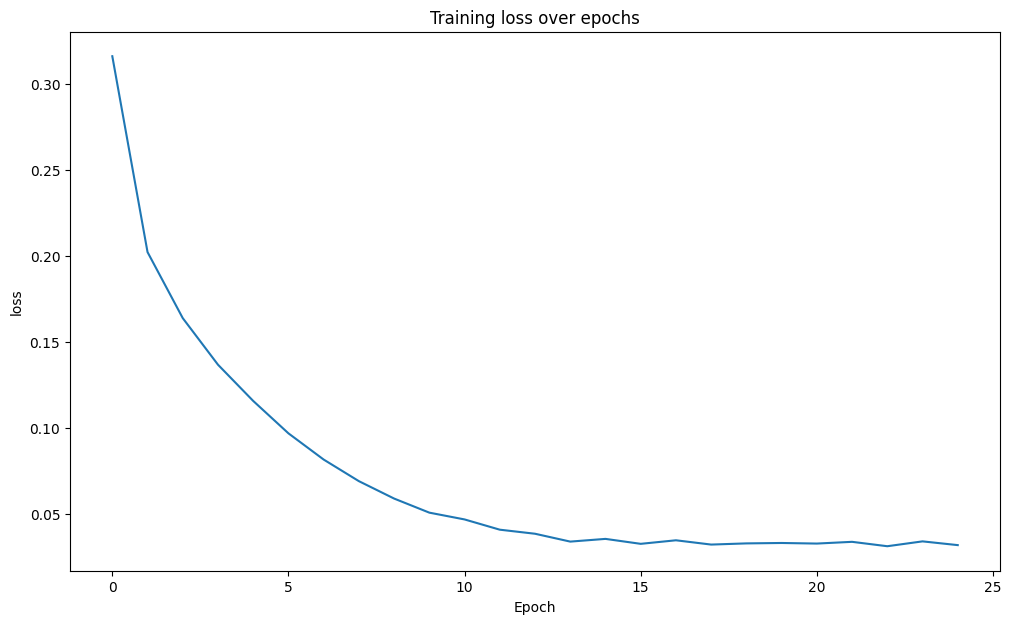

In [68]:
plot_epoch_losses(epoch_losses)

Graph looks good if we keept training the model might get a bit better, we are on the right path!

In [69]:
metrics(y_test.tolist(), eval_neuralnet(model1))

accuracy:0.8719, Precision:0.8898, Recall:0.8512, F1:0.8701


We are actually pretty close to the linear regression but that's not the point...

We need a better model.

How?

    - More epochs
    - Different architecture
    - scale hyperparameters
    - increase TfidfVectorizer size or use Word2vec or different vectorizers

## CNN time

In [70]:
batch_size = 32
drop_out_rate = 0.2
output_shape = 1 # binary 0 , 1
hiddenunits = 16
input_shape = 15000

In [71]:
# vectorize set max_features to 15000 (pc bottleneck)

vectorizer = TfidfVectorizer(max_features=15000)

data_train = vectorizer.fit_transform(X_train)
data_test = vectorizer.transform(X_test)


data_train_dense = data_train.toarray()  # Convert to dense numpy array
data_test_dense = data_test.toarray()
torch.manual_seed(0)

# add to tensor
X_train_tensor = torch.tensor(data_train_dense, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(data_test_dense, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

#Dataset creation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# test and trainloader
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:


class CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, drop_out_rate):
        super().__init__()


        self.convblock1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=hidden_units, kernel_size=3),  # Single channel input
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv1d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Calculate the size after the convolutional and pooling layers
        self.fc_input_size = self._calculate_fc_input(input_shape, hidden_units)
        
        # Fully connected layers
        self.connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(128, output_shape)
        )
    
    def _calculate_fc_input(self, input_shape, hidden_units):
        """
        Calculate the flattened size after convolutional and pooling layers.
        """
        sequence_length = input_shape  # This is the number of features
        # After first conv + pooling
        sequence_length = (sequence_length - 3 + 1) // 2  
        # After second conv + pooling
        sequence_length = (sequence_length - 3 + 1) // 2 
        return hidden_units * sequence_length
    
    def forward(self, x):
        x = x.unsqueeze(1) # unsqueeze  
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.connected(x)
        return x

In [73]:
model2 = CNN(output_shape=output_shape, input_shape=input_shape, hidden_units=hiddenunits, drop_out_rate=drop_out_rate).to(device)

In [74]:

optimizer = optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()
epoch_losses = train_loop(model2, 25, loss_fn, optimizer)


Epoch [1/25], Loss: 0.4987
Epoch [6/25], Loss: 0.0201
Epoch [11/25], Loss: 0.0061
Epoch [16/25], Loss: 0.0030
Epoch [21/25], Loss: 0.0028


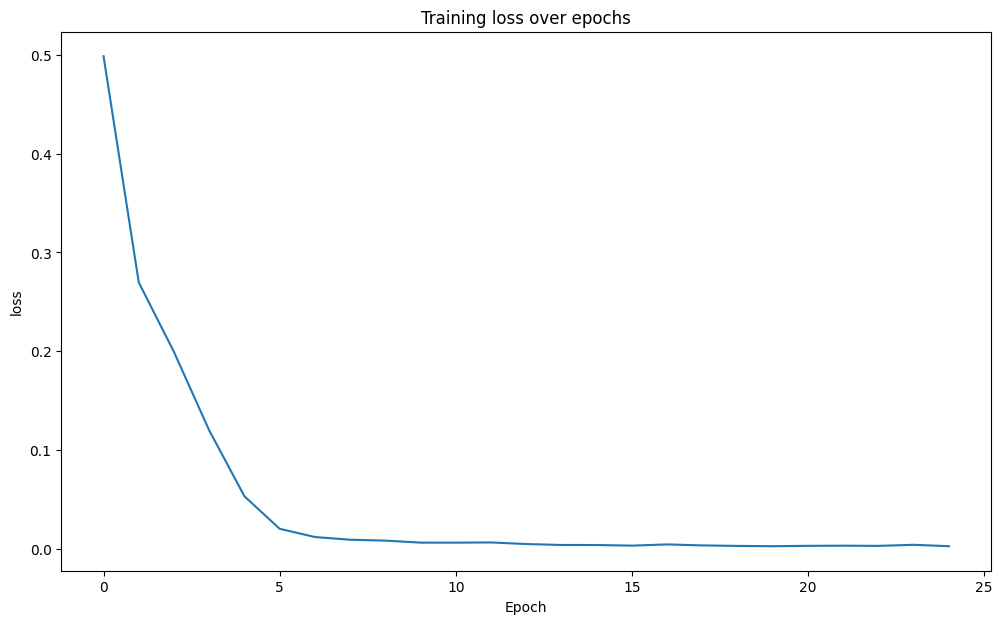

In [75]:
plot_epoch_losses(epoch_losses)

In [76]:
metrics(y_test.tolist(), eval_neuralnet(model2))

accuracy:0.8790, Precision:0.8741, Recall:0.8877, F1:0.8809


25 epochs more dimentionality and a CNN and we got worse values than the linear regression.

Lets try adding more hidden units

# Lets go for a CNN round 2

In [77]:
output_shape = 1 # binary 0 , 1
hiddenunits = 20
input_shape = 10000

In [78]:
vectorizer = TfidfVectorizer(max_features=10000)

data_train = vectorizer.fit_transform(X_train)
data_test = vectorizer.transform(X_test)

data_train_dense = data_train.toarray()  # Convert to dense numpy array
data_test_dense = data_test.toarray()
torch.manual_seed(0)

# add to tensor
X_train_tensor = torch.tensor(data_train_dense, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(data_test_dense, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

#Dataset creation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# test and trainloader
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [79]:
class CNN2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, drop_out_rate):
        super().__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=hidden_units, kernel_size=3),  # Single channel input
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # Calculate the size after the convolutional and pooling layers
        self.fc_input_size = self._calculate_fc_input(input_shape, hidden_units)
        # Fully connected layers
        self.connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_shape)
        )
    
    def _calculate_fc_input(self, input_shape, hidden_units):
        """
        Calculate the flattened size after convolutional and pooling layers.
        """
        sequence_length = input_shape  # This is the number of features
        # After first conv + pooling
        sequence_length = (sequence_length - 3 + 1) // 2  

        return hidden_units * sequence_length
    
    def forward(self, x):
        x = x.unsqueeze(1) # unsqueeze  
        x = self.convblock1(x)
        x = self.connected(x)
        return x

In [80]:
import torch
model3 = CNN2(output_shape=output_shape, input_shape=input_shape, hidden_units=hiddenunits, drop_out_rate=drop_out_rate).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()
epoch_losses = train_loop(model3, 10, loss_fn, optimizer)


Epoch [1/10], Loss: 0.7055
Epoch [6/10], Loss: 0.6932


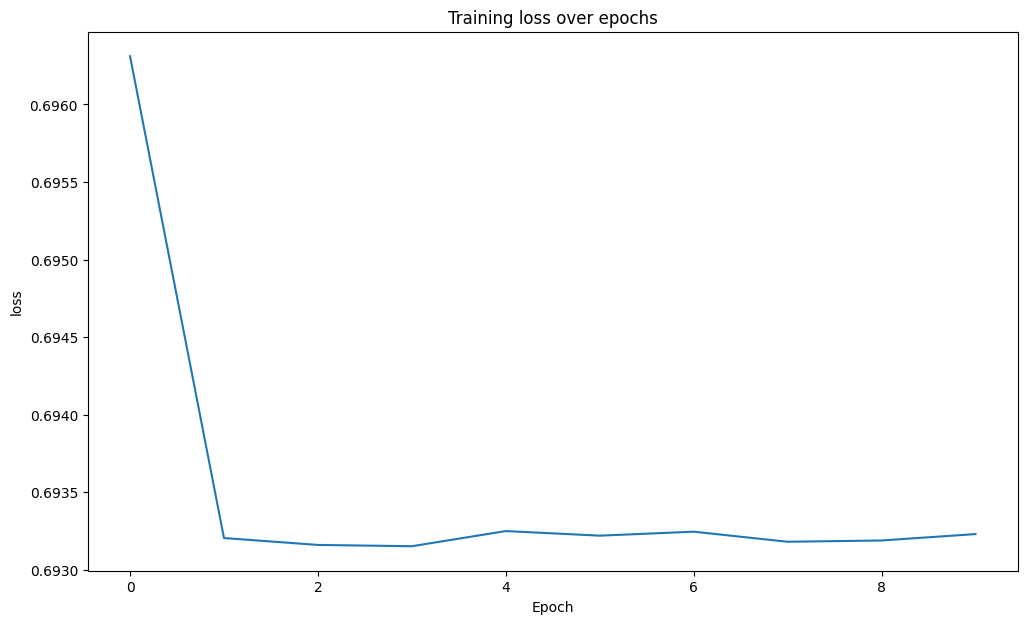

In [23]:
plot_epoch_losses(epoch_losses)

This paper seemingly finds that a simple cnn with little hyperparameters get the job done "Convolutional Neural Networks for Sentence Classification"- Yoon Kim
In our case a simple linear regression turned out better, serveral reason for this could be limited compute working with tiny neural networks, 
But this is just a unfortunte constraint which a student with a 20-series grafics card has to face.

I also want to preface that a dropout layer in this case scenario seems rather strange working with neural networks with incredibly few parameters and very short training, overtraining would most likely not be an issue and maybe compute would be better spent on hidden units or layers.
I think one conclusion is that neural networks might be great at picking up hidden patterns, the compute nessecary might in some cases make a neural network the wrong approach.

If my life depended on it what would I do to make this model better?
The choice of architecture even without the increase in hyperparmeters i neglected in testing a few different neuralnetworks a LSTM could be usable and even perform at a high level, it's important to always test data and models results can always surprise you.
If outcome accuracy is preferred training a existing model on the data would garnish better results, but what's the fun in that?
GPT models could again be trained for the exact same reason as listed above.
Different and more complex vectorizes could be tested, mainly word2vec is a popular one in many AI papers recarding similar topics.

To conclude things in our day age we still shouldn't forget about what got us here linear regression :)